# Music Taste Prediction Model: New Music Friday Recommender 💿🎧👍👎
In this model, I use my liked songs playlist, my recently loved and not loved albums, to train my regression model on what kind of music I do and don't like. At the end my test model will be the new music friday albums from the most recent Friday. 

# Library Imports

In [4]:
# Standard Library Imports
import os
import csv
from datetime import datetime
from time import sleep
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Dict, Tuple, Optional

# Third-Party Imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

# Fuzzy Matching
from fuzzywuzzy import fuzz, process

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform

# Network Analysis
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

# Streamlit (if needed)
import streamlit as st

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Load Datasets

In [6]:
df_liked = pd.read_csv("data/liked.csv")  # Liked playlist on Spotify
df_fav_albums = pd.read_csv("data/liked_albums.csv")  # Albums I've Liked in Recent Years
df_not_liked = pd.read_csv("data/did_not_like.csv")  # Albums I've not liked in Recent Years
df_nmf = pd.read_csv("data/nmf.csv")  # The most recent New Music Friday Playlist
df_liked_similar = pd.read_csv('data/liked_artists_only_similar.csv') #Similar Artisits to My Liked Artists

## A Check for New Artists / Pull Their Similar Artists

In [8]:
#Similar Artist Check/Pull
class LastFMAPI:
    def __init__(self, api_key: str, rate_limit_delay: float = 0.25, limit: int = 5):
        self.api_key = api_key
        self.base_url = "http://ws.audioscrobbler.com/2.0/"
        self.rate_limit_delay = rate_limit_delay
        self.limit = limit

    def get_similar_artists(self, artist_name: str) -> List[str]:
        """Fetch similar artists for a given artist from LastFM API."""
        params = {
            'method': 'artist.getSimilar',
            'artist': artist_name,
            'api_key': self.api_key,
            'limit': self.limit,  # Add limit parameter
            'format': 'json'
        }
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            
            # Handle rate limiting
            if 'X-RateLimit-Remaining' in response.headers:
                remaining = int(response.headers['X-RateLimit-Remaining'])
                if remaining == 0:
                    sleep(self.rate_limit_delay)
            
            data = response.json()
            if 'similarartists' in data and 'artist' in data['similarartists']:
                return [artist['name'] for artist in data['similarartists']['artist'][:self.limit]]
            return []
            
        except Exception as e:
            print(f"Error fetching similar artists for {artist_name}: {e}")
            return []

def extract_primary_artist(artist_string: str) -> str:
    """Extract the first artist name before any comma."""
    if pd.isna(artist_string):
        return ""
    return artist_string.split(",")[0].strip()

def update_similar_artists(liked_path: str, 
                         albums_path: str, 
                         output_path: str, 
                         api_key: str) -> pd.DataFrame:
    """
    Update the similar artists database with new artists from liked playlists.
    Returns the complete DataFrame of artists and their similar artists.
    """
    
    print("Loading existing and new data...")
    
    # Load existing similar artists data
    existing_data: Dict[str, List[str]] = {}
    if os.path.exists(output_path):
        existing_df = pd.read_csv(output_path)
        existing_data = dict(zip(existing_df['Artist'], existing_df['Similar Artists']))
        print(f"Loaded {len(existing_data)} existing artists from database")
    
    # Load and process current playlists
    df_liked = pd.read_csv(liked_path)
    df_albums = pd.read_csv(albums_path)
    
    # Extract and combine primary artists
    current_artists = set(
        pd.concat([
            df_liked['Artist Name(s)'].apply(extract_primary_artist),
            df_albums['Artist Name(s)'].apply(extract_primary_artist)
        ]).unique()
    )
    current_artists.discard("")  # Remove empty strings
    
    # Find new artists not in existing data
    new_artists = current_artists - set(existing_data.keys())
    print(f"Found {len(new_artists)} new artists to process")
    
    if not new_artists:
        print("No new artists to process. Database is up to date!")
        # Create and return DataFrame even if no updates
        return pd.DataFrame({
            'Artist': list(existing_data.keys()),
            'Similar Artists': list(existing_data.values())
        })
    
    # Initialize LastFM API client
    api = LastFMAPI(api_key)
    
    # Process artists with concurrent requests
    results = {}
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_artist = {
            executor.submit(api.get_similar_artists, artist): artist 
            for artist in new_artists
        }
        
        # Show progress bar while processing
        for future in tqdm(as_completed(future_to_artist), 
                         total=len(future_to_artist),
                         desc="Fetching similar artists"):
            artist = future_to_artist[future]
            similar_artists = future.result()
            results[artist] = ', '.join(similar_artists)
    
    # Combine existing and new data
    combined_data = {**existing_data, **results}
    
    # Create DataFrame
    output_df = pd.DataFrame({
        'Artist': list(combined_data.keys()),
        'Similar Artists': list(combined_data.values())
    })
    
    # Save updated data
    output_df.to_csv(output_path, index=False)
    print(f"Successfully updated database with {len(new_artists)} new artists")
    print(f"Total artists in database: {len(combined_data)}")
    
    return output_df

if __name__ == "__main__":
    # Configuration
    API_KEY = "74a510ecc9fc62bf3e0edc6adc2e99f9"
    LIKED_PATH = "data/liked.csv"
    ALBUMS_PATH = "data/liked_albums.csv"
    OUTPUT_PATH = "data/liked_artists_only_similar.csv"
    
    # Run the update and get the DataFrame
    df_liked_similar = update_similar_artists(
        LIKED_PATH, 
        ALBUMS_PATH, 
        OUTPUT_PATH, 
        API_KEY
    )
    
    # Now df_liked_similar is ready to use
    print("\nFirst few rows of the similar artists DataFrame:")
    print(df_liked_similar.head())

Loading existing and new data...
Loaded 2139 existing artists from database
Found 0 new artists to process
No new artists to process. Database is up to date!

First few rows of the similar artists DataFrame:
        Artist                                    Similar Artists
0         RY X                                                NaN
1     The Faim  Oh The Larceny, City Wolf, Random Hero, needsh...
2  Melody Lake  Ian Wong, Limelight Glow, Slow Rising Hope, Po...
3    Liza Anne  Miya Folick, Torres, Billie Marten, Pom Pom Sq...
4    The Kinks  Dave Davies, The Who, Small Faces, The Zombies...


## Quick Glance at our Refreshed Datasets

In [10]:
df_liked.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,4FG86wYpIjIl5NrOr79Fxf,Tough Love,Flyte,"Flyte,Laura Marling",2023-10-27,181763,49,NaN,2025-02-21T03:05:09Z,"singer-songwriter,chamber pop,folk,indie folk",...,2,-6.872,1,0.0288,0.683,0.27200,0.1090,0.6160,119.942,4
1,5KWrRynsADgBtgqoPCh7kn,Words,Waking Up,"Storefront Church,Phoebe Bridgers",2023-02-03,325443,32,NaN,2025-02-20T04:35:16Z,"chamber pop,baroque pop",...,5,-10.978,1,0.0345,0.533,0.02630,0.1070,0.0671,77.883,4
2,7nGN1Wu9kCaKUUdqBcY9NZ,Let Me Go (feat. Madison Cunningham),Let Me Go (feat. Madison Cunningham),"Deep Sea Diver,Madison Cunningham",2025-02-04,282200,40,NaN,2025-02-19T00:45:28Z,NaN,...,4,-4.924,0,0.0308,0.304,0.00000,0.1140,0.3740,127.658,4
3,4r5i6H1OGu3pXkK86DdiD1,Only One,Sock it to Me,Colleen Green,2013-03-19,203573,17,NaN,2025-02-17T20:47:57Z,NaN,...,4,-7.307,1,0.0307,0.292,0.75700,0.0876,0.9520,165.848,4
4,0AAXgVpk3VBbjcwNBNt3Iz,Hope You Find What You're Looking For,Out Of The Blue,Morgan Saint,2025-02-14,190834,16,NaN,2025-02-16T17:59:46Z,NaN,...,6,-8.898,1,0.0372,0.722,0.00154,0.0920,0.6960,104.993,4


In [11]:
# Liked Albums in Recent Years
df_fav_albums.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,0UOeq7bSskoJa4cJaJOmFS,Ticking,Letter to Self,SPRINTS,2024-01-05,186949,28,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,11.0,-6.490,1.0,0.3440,0.02500,0.076500,0.0934,0.291,175.574,4.0
1,02bA26OEe0nNFyE3YcNx4K,Heavy,Letter to Self,SPRINTS,2024-01-05,207409,44,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,11.0,-5.925,1.0,0.0591,0.00435,0.000738,0.0877,0.189,88.581,4.0
2,7IPDhCIQlpvxVxtC1Q7Jq4,Cathedral,Letter to Self,SPRINTS,2024-01-05,179694,28,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,7.0,-6.231,1.0,0.0473,0.00978,0.002700,0.0887,0.397,119.056,4.0
3,65fPteG9ctHt2rrJxlbMr8,Shaking Their Hands,Letter to Self,SPRINTS,2024-01-05,222489,26,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,4.0,-5.658,0.0,0.0533,0.19900,0.108000,0.1330,0.551,89.485,4.0
4,4UgkFdXpJD0fhw06BMk0bz,Adore Adore Adore,Letter to Self,SPRINTS,2024-01-05,157766,33,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,4.0,-4.401,0.0,0.2570,0.01070,0.000107,0.1010,0.402,176.054,4.0


In [12]:
# Albums Not Liked in Recent Years
df_not_liked.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,54KEm0VI9i3ic7VHHKHKRx,¿Cómo Así?,ORQUÍDEAS,Kali Uchis,2024-01-12,169654,55,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,6.0,-7.662,0.0,0.0892,0.04170,0.346000,0.154,0.379,135.985,4.0
1,5mVkTPlTPxlQOn7kEvuM3j,Me Pongo Loca,ORQUÍDEAS,Kali Uchis,2024-01-12,177815,52,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,7.0,-8.680,0.0,0.0426,0.03710,0.152000,0.106,0.407,114.999,4.0
2,6XaJfhwof7qIgbbXO5tIQI,Igual Que Un Ángel (with Peso Pluma),ORQUÍDEAS,"Kali Uchis,Peso Pluma",2024-01-12,260370,75,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,"corrido,corridos tumbados,corridos bélicos,mús...",...,5.0,-5.340,0.0,0.0320,0.00449,0.000663,0.185,0.482,108.001,4.0
3,52x8HIGuk1gGTlvO8CuLNS,Pensamientos Intrusivos,ORQUÍDEAS,Kali Uchis,2024-01-12,192027,59,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,9.0,-8.333,0.0,0.0394,0.57500,0.012900,0.110,0.511,119.994,4.0
4,3RleMgz4iO0BNezGdSxDnY,Diosa,ORQUÍDEAS,Kali Uchis,2024-01-12,156037,57,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,5.0,-5.518,0.0,0.0668,0.06750,0.000101,0.078,0.698,107.994,4.0


In [13]:
# New Music Friday Playlist
df_nmf.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,6gBjUipB0ZxHd1BvwdJTDQ,People Watching,People Watching,Sam Fender,2025-02-21,304480,0,mmr4r23xnc6oh1c77lysfbqg4,2025-02-21T13:23:48Z,NaN,...,6,-4.408,1,0.0662,0.007610,0.000534,0.1170,0.650,161.014,4
1,10MJWoKUV6AthUYR323MqB,Nostalgia's Lie,People Watching,Sam Fender,2025-02-21,250973,0,mmr4r23xnc6oh1c77lysfbqg4,2025-02-21T13:23:48Z,NaN,...,1,-5.459,1,0.0300,0.000896,0.000002,0.0615,0.623,122.044,4
2,66KZtX4hp3Y7JaqmNL5z4i,Chin Up,People Watching,Sam Fender,2025-02-21,203146,0,mmr4r23xnc6oh1c77lysfbqg4,2025-02-21T13:23:48Z,NaN,...,2,-5.302,1,0.0554,0.055300,0.000001,0.2930,0.567,160.867,4
3,5lQS3Q71OZWEA2tt7TcWai,Wild Long Lie,People Watching,Sam Fender,2025-02-21,364533,0,mmr4r23xnc6oh1c77lysfbqg4,2025-02-21T13:23:48Z,NaN,...,6,-6.377,0,0.0271,0.019600,0.000348,0.1060,0.445,82.998,4
4,6ty3uMPCIEGVgGbrvHfeoU,Arm's Length,People Watching,Sam Fender,2025-02-21,239600,0,mmr4r23xnc6oh1c77lysfbqg4,2025-02-21T13:23:48Z,NaN,...,5,-8.155,0,0.0357,0.288000,0.015900,0.3430,0.536,115.917,4


In [14]:
# Similar Artists to Recently Played Artists (Last.fm)

df_liked_similar.head()

,Artist,Similar Artists
0,RY X,NaN
1,The Faim,"Oh The Larceny, City Wolf, Random Hero, needsh..."
2,Melody Lake,"Ian Wong, Limelight Glow, Slow Rising Hope, Po..."
3,Liza Anne,"Miya Folick, Torres, Billie Marten, Pom Pom Sq..."
4,The Kinks,"Dave Davies, The Who, Small Faces, The Zombies..."


> A quick reminder of the standard columns of a spotify export.

In [16]:
df_liked.columns

Index(['Track ID', 'Track Name', 'Album Name', 'Artist Name(s)',
       'Release Date', 'Duration (ms)', 'Popularity', 'Added By', 'Added At',
       'Genres', 'Record Label', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Time Signature'],
      dtype='object')

> What's available in the Similar dataframe?

In [18]:
df_liked_similar.columns

Index(['Artist', 'Similar Artists'], dtype='object')

### Add Target Labels for Training Feature
We need to assign a score to songs I've faved on spotify (100), albums I've enjoyed in recent years (50), and albums that I have not enjoyed in recent years (0) to train the model on the types of songs I don't like, like, and love. 'liked' will be our target variable, later.

In [20]:
# Assign liked scores before combining
df_liked['liked'] = 100
df_fav_albums['liked'] = 50
df_not_liked['liked'] = 0
df_nmf['liked'] = np.nan 

# Add playlist_origin column before combining
df_liked['playlist_origin'] = 'df_liked'
df_fav_albums['playlist_origin'] = 'df_fav_albums'
df_not_liked['playlist_origin'] = 'df_not_liked'
df_nmf['playlist_origin'] = 'df_nmf'
df_liked_similar['source'] = 'liked_similar'

### Check application of the target encoding

In [22]:
df_liked[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,100,df_liked
1,100,df_liked
2,100,df_liked
3,100,df_liked
4,100,df_liked


In [23]:
df_fav_albums[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,50,df_fav_albums
1,50,df_fav_albums
2,50,df_fav_albums
3,50,df_fav_albums
4,50,df_fav_albums


In [24]:
df_not_liked[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,0,df_not_liked
1,0,df_not_liked
2,0,df_not_liked
3,0,df_not_liked
4,0,df_not_liked


In [25]:
df_nmf[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,NaN,df_nmf
1,NaN,df_nmf
2,NaN,df_nmf
3,NaN,df_nmf
4,NaN,df_nmf


In [26]:
df_liked_similar[['Artist', 'Similar Artists', 'source']].head()

,Artist,Similar Artists,source
0,RY X,NaN,liked_similar
1,The Faim,"Oh The Larceny, City Wolf, Random Hero, needsh...",liked_similar
2,Melody Lake,"Ian Wong, Limelight Glow, Slow Rising Hope, Po...",liked_similar
3,Liza Anne,"Miya Folick, Torres, Billie Marten, Pom Pom Sq...",liked_similar
4,The Kinks,"Dave Davies, The Who, Small Faces, The Zombies...",liked_similar


## Data Cleaning 🧹

## Merge The Datasets

In [29]:
df = pd.concat([df_liked, df_fav_albums, df_not_liked, df_nmf], ignore_index=True)

In [30]:
#How Large is the Dataset, Now?
df.shape

(13662, 25)

#### Remove the Duplicates 🔥

In [32]:
# Remove duplicates: Keep the highest 'liked' score (100 > 50)
df = df.sort_values(by='liked', ascending=False)  # Ensures 100-rated songs come first
df = df.drop_duplicates(subset=['Track Name', 'Artist Name(s)'], keep='first')
df.shape

(11413, 25)

#### Drop columns that won't help the model 💣

In [76]:
df.drop(columns=['Added By', 'Added At', 'Time Signature'], inplace=True)

KeyError: "['Added By', 'Added At', 'Time Signature'] not found in axis"

#### Handle missing values (if any)

In [36]:
 df.isna().sum()

Track Name             0
Album Name             0
Artist Name(s)         0
Release Date           0
Duration (ms)          0
Popularity             0
Genres              5703
Record Label           3
Danceability           7
Energy                 7
Key                    7
Loudness               7
Mode                   7
Speechiness            7
Acousticness           7
Instrumentalness       7
Liveness               7
Valence                7
Tempo                  7
liked                455
playlist_origin        0
dtype: int64

## Getting New Genre Data From Last.fm 🟢🎵

In [38]:
class LastFMGenreFetcher:
    def __init__(self, api_key: str, rate_limit_delay: float = 0.25):
        self.api_key = api_key
        self.base_url = "http://ws.audioscrobbler.com/2.0/"
        self.rate_limit_delay = rate_limit_delay
        
    def _make_request(self, params: Dict) -> Dict:
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            sleep(self.rate_limit_delay)  # Basic rate limiting
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"API request failed for params {params}: {e}")
            if getattr(response, 'status_code', None) == 429:
                print("Rate limit exceeded, increasing delay.")
                self.rate_limit_delay *= 2
                sleep(5)  # Wait before retry
            return None

    def get_artist_tags(self, artist_name: str) -> List[str]:
        params = {
            'method': 'artist.getTopTags',
            'artist': artist_name,
            'api_key': self.api_key,
            'format': 'json'
        }
        data = self._make_request(params)
        
        if not data or 'toptags' not in data:
            return []
            
        tags = []
        for tag in data['toptags'].get('tag', []):
            tag_name = tag['name'].lower()
            # Skip 'seen live' tag and prioritize 'female vocalist'
            if tag_name == 'seen live':
                continue
            if tag_name == 'female vocalists' or tag_name == 'female vocalist':
                tags.insert(0, 'female vocalist')  # Standardize and prioritize
            else:
                tags.append(tag_name)
                
        return tags[:10]  # Return up to 10 tags

def update_genre_data(api_key: str, dataframes: List[pd.DataFrame], output_file: str = 'data/ten_genres.csv') -> None:
    # Initialize the API client
    api = LastFMGenreFetcher(api_key)
    
    # Get all unique artists from the dataframes
    all_artists = set()
    for df in dataframes:
        if 'Artist Name(s)' in df.columns:
            artists = df['Artist Name(s)'].apply(lambda x: x.split(',')[0].strip() if pd.notna(x) else None)
            all_artists.update(artist for artist in artists if artist)
    
    # Load existing data
    existing_data = {}
    try:
        if os.path.exists(output_file) and os.path.getsize(output_file) > 0:
            existing_data = pd.read_csv(output_file).set_index('Artist')['Genres'].to_dict()
    except (pd.errors.EmptyDataError, KeyError):
        print("No existing genre data found or file is empty. Starting fresh.")
    
    # Load obscure artist genres and merge
    obscure_artists = pd.read_csv("data/obscure_artists_mike_likes.csv", quotechar='"')
    obscure_artists_dict = pd.Series(obscure_artists["Genres"].values, index=obscure_artists["Artist"]).to_dict()
    
    # Merge genres from obscure artists with existing data
    existing_data.update(obscure_artists_dict)
    
    # Identify new artists that aren't in existing data or obscure_artists
    new_artists = [artist for artist in all_artists if artist not in existing_data]
    
    if not new_artists:
        print("No new artists to process!")
        return
    
    print(f"Found {len(new_artists)} new artists to process")
    
    # Process new artists with ThreadPoolExecutor
    results = {}
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_artist = {executor.submit(api.get_artist_tags, artist): artist 
                          for artist in new_artists}
        
        completed = 0
        for future in as_completed(future_to_artist):
            artist = future_to_artist[future]
            try:
                tags = future.result()
                if tags:
                    results[artist] = ', '.join(tags)
                completed += 1
                if completed % 50 == 0 or (len(new_artists) < 50 and completed % 10 == 0):
                    print(f"Processed {completed}/{len(new_artists)} artists")
            except Exception as e:
                print(f"Error processing {artist}: {e}")
    
    # Combine existing and new data
    all_data = {**existing_data, **results}
    
    # Save to CSV
    df_output = pd.DataFrame(
        [{'Artist': artist, 'Genres': genres} 
         for artist, genres in all_data.items()]
    )
    df_output.to_csv(output_file, index=False)
    print(f"\nSuccessfully updated {output_file} with {len(results)} new artists!")

# Example usage:
if __name__ == "__main__":
    API_KEY = '74a510ecc9fc62bf3e0edc6adc2e99f9'

    # Update genre data
    update_genre_data(API_KEY, [df], 'data/ten_genres.csv')

    # Load the ten_genres.csv file
    ten_genres = pd.read_csv("data/ten_genres.csv")

    # Extract the primary artist (before the comma)
    df["Primary Artist"] = df["Artist Name(s)"].str.split(",").str[0]
    ten_genres["Primary Artist"] = ten_genres["Artist"].str.split(",").str[0]

    # Merge, prioritizing ten_genres
    df = df.merge(ten_genres[["Primary Artist", "Genres"]], on="Primary Artist", how="left", suffixes=("", "_ten"))

    # If ten_genres has a match, use it; otherwise, keep the original
    df["Genres"] = df["Genres_ten"].combine_first(df["Genres"])

    # Drop the extra columns
    df.drop(columns=["Genres_ten", "Primary Artist"], inplace=True)

df.head()


Found 75 new artists to process
Processed 50/75 artists

Successfully updated data/ten_genres.csv with 2 new artists!


,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Genres,Record Label,Danceability,Energy,...,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,liked,playlist_origin
0,Tough Love,Flyte,"Flyte,Laura Marling",2023-10-27,181763,49,"progressive rock, symphonic prog, indie rock, ...",Nettwerk Music Group,0.739,0.622,...,-6.872,1.0,0.0288,0.68300,0.272000,0.1090,0.616,119.942,100.0,df_liked
1,Zoom,Jesus At The Gay Bar,Cub Sport,2023-04-07,209816,0,"australian, pop, indie pop, indie, power pop, ...",Cub Sport Records / Believe,0.474,0.472,...,-8.505,1.0,0.0295,0.40900,0.000000,0.3640,0.232,115.935,100.0,df_liked
2,Tongue,Drop Cherries,Billie Marten,2023-04-07,250541,19,"female vocalist, female vocalist, indie, folk,...",Fiction Records,0.399,0.174,...,-12.344,1.0,0.0330,0.98200,0.066300,0.1100,0.153,137.665,100.0,df_liked
3,This Is Paradise (But Not For Us),Strange Strangers,Devon Church,2023-04-07,317368,0,"indie rock, folk, dub, shoegaze, dream pop, fo...",felte,0.293,0.598,...,-7.561,1.0,0.0385,0.00739,0.000089,0.0790,0.391,183.905,100.0,df_liked
4,Time To Pretend,Time To Pretend,Charlie Hickey,2023-03-21,208050,15,"indie, folk, indie pop, indie rock, american, ...",Dead Oceans,0.689,0.259,...,-11.673,1.0,0.0333,0.86900,0.000029,0.0984,0.341,99.950,100.0,df_liked


### Save a copy of the missing genre artists in case i want to fuss with it!

In [40]:
# Load the ten_genres.csv file
ten_genres = pd.read_csv("data/ten_genres.csv")

# Extract the primary artist from both datasets
df["Primary Artist"] = df["Artist Name(s)"].str.split(",").str[0].str.strip()
ten_genres["Primary Artist"] = ten_genres["Artist"].str.split(",").str[0].str.strip()

# Identify missing artists
missing_artists = df[~df["Primary Artist"].isin(ten_genres["Primary Artist"])]

# Save to CSV
missing_artists[["Primary Artist"]].drop_duplicates().to_csv("data/missing_artists.csv", index=False)

print(f"Saved {len(missing_artists)} missing artists to 'data/missing_artists.csv'.")

# remaining missing artists will be in data/missing_artists.csv, you can manually pick genres
# if you so choose and place in obscure_artists_mike_likes.csv!

Saved 166 missing artists to 'data/missing_artists.csv'.


In [41]:
df.isna().sum()

Track Name            0
Album Name            0
Artist Name(s)        0
Release Date          0
Duration (ms)         0
Popularity            0
Genres              112
Record Label          3
Danceability          7
Energy                7
Key                   7
Loudness              7
Mode                  7
Speechiness           7
Acousticness          7
Instrumentalness      7
Liveness              7
Valence               7
Tempo                 7
liked               455
playlist_origin       0
Primary Artist        0
dtype: int64

In [42]:
# Drop rows with nulls in any column except 'liked'
df = df[df.drop(columns=['liked']).notna().all(axis=1)].reset_index(drop=True)

In [43]:
 df.isna().sum()

Track Name            0
Album Name            0
Artist Name(s)        0
Release Date          0
Duration (ms)         0
Popularity            0
Genres                0
Record Label          0
Danceability          0
Energy                0
Key                   0
Loudness              0
Mode                  0
Speechiness           0
Acousticness          0
Instrumentalness      0
Liveness              0
Valence               0
Tempo                 0
liked               450
playlist_origin       0
Primary Artist        0
dtype: int64

In [44]:
df.shape

(11292, 22)

In [45]:
# Count how many of each 'playlist_origin' are in the df dataset
playlist_origin_counts = df['playlist_origin'].value_counts()

print("Playlist Origin Counts:")
print(playlist_origin_counts)


Playlist Origin Counts:
playlist_origin
df_fav_albums    5575
df_liked         4066
df_not_liked     1201
df_nmf            450
Name: count, dtype: int64


# Feature Engineering / Further Selecting 👌

## Target Encoding Record Labels
Record labels are currently having an outsized influence on the model, making up 48% of feature importance (at the time of this addition to the model). This is mainly due to the target encoding being too granular, with hundreds of individual labels. To address this, we're grouping labels by size and frequency first. This helps reduce the risk of overfitting to smaller labels, creates more meaningful categories based on their reach and influence, and makes it easier to handle rare or lesser-known labels without distorting the model.

In [48]:
# The Labels are categorized by quartile by how frequently they appear in the dataset,
# Those quartiles are then target encoded on the target variable 'liked'

def categorize_labels_by_size(df):
    # Count number of tracks per label
    label_counts = df[df['playlist_origin'] != 'df_nmf']['Record Label'].value_counts()
    
    # Calculate percentiles
    p75 = label_counts.quantile(0.75)
    p25 = label_counts.quantile(0.25)
    
    # Create category mapping
    label_categories = {}
    for label, count in label_counts.items():
        if count >= p75:
            label_categories[label] = 'Large Label'
        elif count <= p25:
            label_categories[label] = 'Small Label'
        else:
            label_categories[label] = 'Medium Label'
    
    # Map unknown labels to 'Unknown/DIY'
    df['Label_Category'] = df['Record Label'].map(label_categories).fillna('Unknown/DIY')
    
    # Print some statistics about the categorization
    print("\nLabel Category Distribution:")
    print(df['Label_Category'].value_counts())
    print("\nSample of Large Labels:", 
          list(label for label, count in label_counts.items() if count >= p75)[:5])
    
    return df

def target_encode_categories(df, column, target, smoothing=35, boost_small_labels=1.5):
    # Separate out df_nmf to ensure it's never used in encoding
    df_train = df[df['playlist_origin'] != 'df_nmf'].copy()
    mean_target = df_train[target].mean()
    
    # Calculate encoding values for each category
    label_means = df_train.groupby(column)[target].mean()
    label_counts = df_train[column].value_counts()
    
    # Calculate the smoothed encoding values
    smoothed_values = (label_means * label_counts + mean_target * smoothing) / (label_counts + smoothing)
    
    # Apply boost to small labels
    small_labels = df['Label_Category'] == 'Small Label'
    
    # Align indices between small_labels and smoothed_values
    for label in smoothed_values.index:
        if label == 'Small Label':
            smoothed_values[label] *= boost_small_labels
    
    # Map with a fallback to the overall mean
    df[column + '_encoded'] = df[column].map(smoothed_values).fillna(mean_target)
    
    return df

# Apply the categorization and encoding
df = categorize_labels_by_size(df)
df = target_encode_categories(df, 'Label_Category', 'liked', smoothing=35)

# Print sample of results
print("\nSample of encoded values:")
print(df[['Label_Category', 'Label_Category_encoded', 'liked']].head())



Label Category Distribution:
Label_Category
Large Label     8958
Medium Label    1308
Small Label      769
Unknown/DIY      257
Name: count, dtype: int64

Sample of Large Labels: ['Anti/Epitaph', 'Mom+Pop', 'Columbia', 'Loma Vista Recordings', 'Dead Oceans']

Sample of encoded values:
  Label_Category  Label_Category_encoded  liked
0    Large Label               57.120837  100.0
1    Small Label              147.345225  100.0
2    Large Label               57.120837  100.0
3   Medium Label               83.203965  100.0
4    Large Label               57.120837  100.0


## Target Encode Genres 🎚

In [50]:
#temporarily removing to see if model performs better than 67%
#This code explodes the list of genres for each song onto their own line,
#target encodes, or gives a typical like score for each genre, then
#averages the score for each genre of that song, and leaves that as its
#target encoded score!

# Create a binary indicator column for 'Unknown' genres
df['is_unknown_genre'] = (df['Genres'] == 'Unknown').astype(int)

# Define the target encoding function
def target_encode_multi_genre(df, genre_column, target, smoothing=1, aggregation_method='mean', nmf_fallback=0):
    """
    Target encode a multi-genre column by splitting genres, encoding individually, and aggregating.
    Explicitly handles 'Unknown' genres and NMF rows.
    """
    # Separate out df_nmf to ensure it's never used in encoding
    df_train = df[df['playlist_origin'] != 'df_nmf'].copy()

    # Calculate the global mean of the target variable
    global_mean = df_train[target].mean()

    # Split genres into individual categories and exclude 'seen live' and 'Unknown'
    df_train['split_genres'] = df_train[genre_column].str.split(', ').apply(
        lambda x: [genre for genre in x if genre != 'seen live' and genre != 'Unknown'] if isinstance(x, list) else x
    )

    # Explode the list of genres into separate rows
    exploded_genres = df_train.explode('split_genres')

    # Calculate target encoding for individual genres
    label_means = exploded_genres.groupby('split_genres')[target].mean()
    label_counts = exploded_genres['split_genres'].value_counts()

    # Calculate smoothed target encoding for individual genres
    smoothed_values = (label_means * label_counts + global_mean * smoothing) / (label_counts + smoothing)

    # Map the smoothed values back to the exploded genres
    exploded_genres['genre_encoded'] = exploded_genres['split_genres'].map(smoothed_values).fillna(global_mean)

    # Aggregate encodings for multi-genre rows
    if aggregation_method == 'mean':
        aggregated_encodings = exploded_genres.groupby(exploded_genres.index)['genre_encoded'].mean()
    elif aggregation_method == 'max':
        aggregated_encodings = exploded_genres.groupby(exploded_genres.index)['genre_encoded'].max()
    else:
        raise ValueError(f"Unsupported aggregation method: {aggregation_method}")

    # Add the aggregated encodings to the original dataframe
    df[genre_column + '_encoded'] = aggregated_encodings

    # Handle 'Unknown' genres
    is_unknown = df[genre_column] == 'Unknown'
    df.loc[is_unknown, genre_column + '_encoded'] = global_mean  # Use global mean for non-NMF rows

    # Handle NMF rows with 'Unknown' genres separately
    is_nmf = df['playlist_origin'] == 'df_nmf'
    df.loc[is_nmf & is_unknown, genre_column + '_encoded'] = nmf_fallback  # Use nmf_fallback for NMF rows

    return df

# Apply the target encoding function
df = target_encode_multi_genre(df, 'Genres', 'liked', smoothing=35, nmf_fallback=0)

# Inspect the results
print(df[['Genres', 'Genres_encoded', 'is_unknown_genre', 'liked', 'playlist_origin']].head())

                                              Genres  Genres_encoded  \
0  progressive rock, symphonic prog, indie rock, ...       66.710706   
1  australian, pop, indie pop, indie, power pop, ...       63.772345   
2  female vocalist, female vocalist, indie, folk,...       67.217297   
3  indie rock, folk, dub, shoegaze, dream pop, fo...       66.119779   
4  indie, folk, indie pop, indie rock, american, ...       67.740965   

   is_unknown_genre  liked playlist_origin  
0                 0  100.0        df_liked  
1                 0  100.0        df_liked  
2                 0  100.0        df_liked  
3                 0  100.0        df_liked  
4                 0  100.0        df_liked  


### Checking the distribution of Genres_encoded by playlist_origin

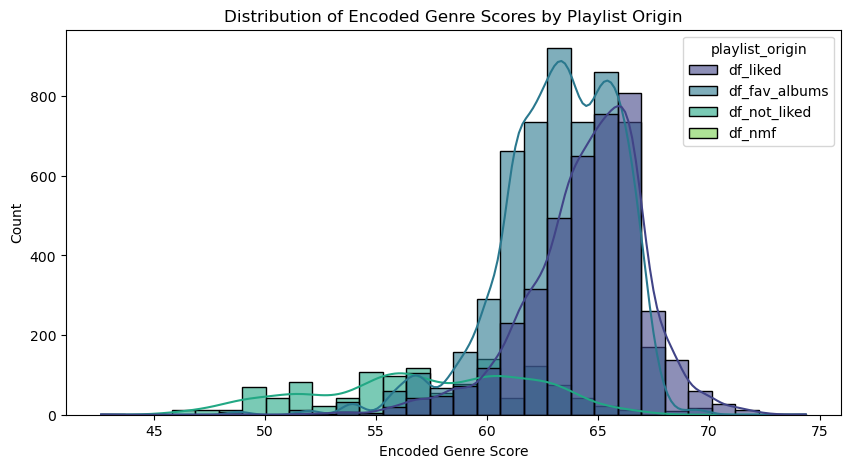

In [52]:
# Set figure size
plt.figure(figsize=(10, 5))

# Plot the distribution of Genres_encoded, colored by playlist_origin
sns.histplot(df, x='Genres_encoded', bins=30, hue='playlist_origin', kde=True, alpha=0.6, palette='viridis')

# Labels and title
plt.xlabel('Encoded Genre Score')
plt.ylabel('Count')
plt.title('Distribution of Encoded Genre Scores by Playlist Origin')

plt.show()

## Finding How Central an Artist is to My Music Taste 🎯
This code builds a network of artists based on which ones are liked and which are similar to them. It then calculates how important each artist is in the network using a method called PageRank. The final scores, showing each artist’s "centrality," are added to the dataset and scaled from 0 to 100, giving us a measure of an artist's influence within the group.

### It also Finds Featured Artists, Who Gave the Album Their Co-Sign ✍
This feature was inspired by Denison Witmer, who on Valentines day 2025 released a lovely album where Sufjan features on multiple songs. I love Sufjan, and didnt know the two were frequent collaborators. This sometimes could help an obscure artist reach new hights.

In [55]:
# First, create the Featured_Artist(s) column
def extract_featured_artists(df):
    # Create new column by splitting on comma and taking all but first artist
    df['Featured_Artist(s)'] = df['Artist Name(s)'].apply(
        lambda x: ', '.join(str(x).split(',')[1:]).strip() if ',' in str(x) else ''
    )
    return df

# Prepare the data
def prepare_featured_artists(df):
    # First create the column if it doesn't exist
    df = extract_featured_artists(df)
    
    # Ensure 'Featured_Artist(s)' is a string and handle missing values
    df['Featured_Artist(s)'] = df['Featured_Artist(s)'].fillna('').astype(str)
    
    # Split and clean the 'Featured_Artist(s)' column into lists
    df['Featured_Artist(s)'] = df['Featured_Artist(s)'].str.split(',').apply(
        lambda x: [artist.strip() for artist in x] if isinstance(x, list) else []
    )
    return df

def build_graph(df, df_liked_similar):
    """Build a graph of artists and their connections."""
    G = nx.Graph()
    
    # Add nodes for liked artists
    liked_artists = set(
        df[df['playlist_origin'].isin(['df_liked', 'df_fav_albums'])]['Artist Name(s)']
        .str.split(',').explode().str.strip()
    )
    G.add_nodes_from(liked_artists, type='liked')
    
    # Add nodes for similar artists (from liked)
    similar_artists_liked = set(
        df_liked_similar['Similar Artists']
        .dropna()
        .str.split(',').explode().str.strip()
    )
    G.add_nodes_from(similar_artists_liked, type='similar_liked')
    
    # Add edges based on similarity (from liked)
    for _, row in df_liked_similar.iterrows():
        artist = row['Artist']
        if isinstance(row['Similar Artists'], str):
            similar = row['Similar Artists'].split(', ')
            for s in similar:
                G.add_edge(artist, s, weight=1.0)
    
    # Add nodes for featured artists
    featured_artists = set()
    for artists in df['Featured_Artist(s)']:
        if artists:  # Check if the list is not empty
            featured_artists.update(artists)
    G.add_nodes_from(featured_artists, type='featured')
    
    return G

def calculate_centrality_scores(G, df):
    """Calculate PageRank centrality for all artists in the graph."""
    centrality_scores = nx.pagerank(G)
    
    # Map centrality scores back to DataFrame for main artists
    df['Artist Centrality'] = (
        df['Artist Name(s)']
        .str.split(',').str[0].str.strip()
        .map(centrality_scores).fillna(0)
    )
    
    # Map centrality scores back to DataFrame for featured artists
    df['Featured_Centrality_Score'] = df['Featured_Artist(s)'].apply(
        lambda x: np.mean([centrality_scores.get(artist, 0) for artist in x if artist in centrality_scores]) if x else 0
    )
    return df, centrality_scores

def normalize_centrality_scores(df):
    """Normalize centrality scores to 0-100 range."""
    if df['Artist Centrality'].max() != 0:
        df['Artist Centrality'] = (df['Artist Centrality'] / df['Artist Centrality'].max()) * 100
    if df['Featured_Centrality_Score'].max() != 0:
        df['Featured_Centrality_Score'] = (df['Featured_Centrality_Score'] / df['Featured_Centrality_Score'].max()) * 100
    return df

# Run the complete pipeline
def run_centrality_analysis(df, df_liked_similar):
    # Prepare the featured artists data
    df = prepare_featured_artists(df)
    
    # Build the graph and calculate centrality
    G = build_graph(df, df_liked_similar)
    df, centrality_scores = calculate_centrality_scores(G, df)
    df = normalize_centrality_scores(df)
    
    return df, G, centrality_scores

# Execute the analysis
df, G, centrality_scores = run_centrality_analysis(df, df_liked_similar)

# Filter songs where 'Featured_Artist(s)' is not empty or a missing value
df_with_featured = df[df['Featured_Artist(s)'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

# Get the top 5 rows with highest 'Artist Centrality' scores
top_artist_df = df.nlargest(5, 'Artist Centrality')[['Artist Name(s)', 'Artist Centrality']]

# Get the top 5 rows with highest 'Featured_Centrality_Score' scores (if any featured artists exist)
df_with_featured = df[df['Featured_Artist(s)'].apply(lambda x: len(x) > 0)]  # Ensure featured artists exist
top_featured_df = df_with_featured.nlargest(5, 'Featured_Centrality_Score')[['Featured_Artist(s)', 'Featured_Centrality_Score']]

# Print bite-sized samples of both
print("\nTop 5 Regular Artists by Centrality:")
print(top_artist_df)

print("\nTop 5 Featured Artists by Centrality:")
print(top_featured_df)



Top 5 Regular Artists by Centrality:
      Artist Name(s)  Artist Centrality
1689     Molly Sarlé         100.000000
942         WebsterX          93.057283
3419  String Machine          91.029561
1299       Bob Dylan          90.060102
323    Generationals          90.048300

Top 5 Featured Artists by Centrality:
     Featured_Artist(s)  Featured_Centrality_Score
1173  [Jess Williamson]                      100.0
5601  [Jess Williamson]                      100.0
5604  [Jess Williamson]                      100.0
5605  [Jess Williamson]                      100.0
5608  [Jess Williamson]                      100.0


## Two More Features Before Primetime! 🎭

**Mood Score**: Combines Valence, Danceability, and Liveness to capture the vibe.

**Energy Profile**: Mashes Energy, Loudness, and Tempo to gauge the track’s intensity.


In [57]:
# Calculate features only on non-NMF data
non_nmf_df = df[df['playlist_origin'] != 'df_nmf'].copy()

# Create mood_score and energy_profile on non-NMF data
non_nmf_df['mood_score'] = non_nmf_df[['Valence', 'Danceability', 'Liveness']].mean(axis=1)
non_nmf_df['energy_profile'] = non_nmf_df[['Energy', 'Loudness', 'Tempo']].mean(axis=1)

# Merge these features back into the main dataframe
df = df.merge(non_nmf_df[['mood_score', 'energy_profile']], how='left', left_index=True, right_index=True)

## Previwing the features on the menu 📖

In [59]:
df.columns

Index(['Track Name', 'Album Name', 'Artist Name(s)', 'Release Date',
       'Duration (ms)', 'Popularity', 'Genres', 'Record Label', 'Danceability',
       'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'liked',
       'playlist_origin', 'Primary Artist', 'Label_Category',
       'Label_Category_encoded', 'is_unknown_genre', 'Genres_encoded',
       'Featured_Artist(s)', 'Artist Centrality', 'Featured_Centrality_Score',
       'mood_score', 'energy_profile'],
      dtype='object')

In [60]:
df.dtypes

Track Name                    object
Album Name                    object
Artist Name(s)                object
Release Date                  object
Duration (ms)                  int64
Popularity                     int64
Genres                        object
Record Label                  object
Danceability                 float64
Energy                       float64
Key                          float64
Loudness                     float64
Mode                         float64
Speechiness                  float64
Acousticness                 float64
Instrumentalness             float64
Liveness                     float64
Valence                      float64
Tempo                        float64
liked                        float64
playlist_origin               object
Primary Artist                object
Label_Category                object
Label_Category_encoded       float64
is_unknown_genre               int32
Genres_encoded               float64
Featured_Artist(s)            object
A

## Standardize the numeric columns 📏
When some numbers have a larger size than others, the model can be biased towards them, so we bring all the numeric columns on a similar scale.

### Seperate New Music Friday and Save it for Later!

In [63]:
# Calculate mood and energy scores first
df['mood_score'] = df[['Valence', 'Danceability', 'Liveness']].mean(axis=1)
df['energy_profile'] = df[['Energy', 'Loudness', 'Tempo']].mean(axis=1)

# Split and save data
df_nmf = df[df['playlist_origin'] == 'df_nmf'].copy()
df = df[df['playlist_origin'] != 'df_nmf'].copy()

# Save both versions pre-standardization
df_nmf.to_csv('data/df_nmf_later.csv', index=False)
df_cleaned_pre_standardized = pd.concat([df, df_nmf], ignore_index=True)
df_cleaned_pre_standardized.to_csv('data/df_cleaned_pre_standardized.csv', index=False)

# Store original values
original_centrality = df_nmf['Artist Centrality'].copy()
original_mood = df_nmf['mood_score'].copy()
original_energy = df_nmf['energy_profile'].copy()

In [64]:
# Define numeric columns to standardize
numeric_columns = [
    'Duration (ms)', 'Popularity', 'Danceability', 'Energy', 'Key', 'Loudness',
    'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
    'Valence', 'Tempo', 'Featured_Centrality_Score',
    'Artist Centrality', 'Label_Category_encoded', 'mood_score', 'energy_profile'
]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data (df)
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Transform the test data (df_nmf) using the fitted scaler
df_nmf[numeric_columns] = scaler.transform(df_nmf[numeric_columns])

# Save the standardized df_nmf for later use
df_nmf.to_csv('data/df_nmf_later.csv', index=False)

In [65]:
df_nmf[numeric_columns].head()

,Duration (ms),Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Featured_Centrality_Score,Artist Centrality,Label_Category_encoded,mood_score,energy_profile
10842,1.295842,-1.157048,-0.422466,1.480832,0.230043,1.118488,0.598303,-0.099156,-1.035826,-0.454106,-0.468818,0.934049,1.373280,-0.233937,-1.598367,-0.395517,0.226615,1.482128
10843,0.529483,-1.157048,-0.054160,1.054861,-1.164101,0.835024,0.598303,-0.481510,-1.055899,-0.456311,-0.863887,0.817495,0.058592,-0.233937,-1.598367,-0.395517,0.162328,0.166516
10844,-0.155524,-1.157048,-0.784530,1.102191,-0.885272,0.877368,0.598303,-0.213228,-0.893243,-0.456314,0.784012,0.575754,1.368320,-0.233937,-1.598367,-0.395517,0.322361,1.445106
10845,2.155958,-1.157048,-0.566043,0.517019,0.230043,0.587430,-1.671395,-0.512141,-0.999978,-0.454877,-0.547120,0.049104,-1.258659,-0.233937,-1.598367,-0.395517,-0.427198,-1.148079
10846,0.366592,-1.157048,1.075729,0.177102,-0.048786,0.107887,-1.671395,-0.421305,-0.197520,-0.390405,1.139930,0.441933,-0.148108,-0.233937,-1.598367,-0.395517,1.189552,-0.129497


## Tuning and Predicting with Random Forest & XGBoost 🌟
In this section, we fine-tune our Random Forest and XGBoost models using randomized search for optimal hyperparameters. The goal? To get the best possible performance in predicting song ratings. After tuning the models, we make predictions on the unseen data, combining both models' results to generate a more accurate score!

In [67]:
def tune_models(df, features, test_size=0.2):
    # Prepare data
    X = df[features]
    y = (df['liked'] - df['liked'].mean()) / df['liked'].std()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # RandomForest parameters
    rf_params = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 15),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5)
    }
    
    # XGBoost parameters
    xgb_params = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    }
    
    # Initialize models
    rf = RandomForestRegressor(random_state=42)
    xgb = XGBRegressor(random_state=42)
    
    # Perform randomized search
    rf_search = RandomizedSearchCV(
        rf, rf_params, n_iter=20, cv=5, scoring='neg_mean_squared_error',
        random_state=42, n_jobs=-1
    )
    xgb_search = RandomizedSearchCV(
        xgb, xgb_params, n_iter=20, cv=5, scoring='neg_mean_squared_error',
        random_state=42, n_jobs=-1
    )
    
    # Fit models
    rf_search.fit(X_train, y_train)
    xgb_search.fit(X_train, y_train)
    
    # Train final models with best parameters
    best_rf = RandomForestRegressor(**rf_search.best_params_, random_state=42)
    best_xgb = XGBRegressor(**xgb_search.best_params_, random_state=42)
    
    best_rf.fit(X_train, y_train)
    best_xgb.fit(X_train, y_train)
    
    return best_rf, best_xgb, rf_search.best_params_, xgb_search.best_params_

def predict_with_tuned_models(best_rf, best_xgb, df_nmf, features, y_mean, y_std):
    # Make predictions
    rf_pred = best_rf.predict(df_nmf[features]) * y_std + y_mean
    xgb_pred = best_xgb.predict(df_nmf[features]) * y_std + y_mean
    
    # Combine predictions
    df_nmf['predicted_score'] = (rf_pred + xgb_pred) / 2
    
    return df_nmf

# Usage
features = [
    'Popularity','Genres_encoded', 'Artist Centrality',
    'Label_Category_encoded', 'mood_score', 'energy_profile', 'Featured_Centrality_Score'
]

best_rf, best_xgb, rf_params, xgb_params = tune_models(df, features)
df_nmf = predict_with_tuned_models(best_rf, best_xgb, df_nmf, features, df['liked'].mean(), df['liked'].std())

# Output best parameters and feature importances
print(f"Random Forest best parameters: {rf_params}")
print(f"XGBoost best parameters: {xgb_params}")
print(f"Random Forest feature importances: {best_rf.feature_importances_}")
print(f"XGBoost feature importances: {best_xgb.feature_importances_}")

# Feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature importance (Random Forest):")
print(feature_importance)

# Save outputs to CSV for future review
rf_params_df = pd.DataFrame([rf_params], index=['Random Forest'])
xgb_params_df = pd.DataFrame([xgb_params], index=['XGBoost'])
feature_importance.to_csv('feature_params/feature_importance.csv')
rf_params_df.to_csv('feature_params/rf_params.csv')
xgb_params_df.to_csv('feature_params/xgb_params.csv')

Random Forest best parameters: {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 253}
XGBoost best parameters: {'colsample_bytree': 0.8281775897621597, 'learning_rate': 0.1662502780077471, 'max_depth': 8, 'n_estimators': 89, 'subsample': 0.9378135394712606}
Random Forest feature importances: [0.07167569 0.20257926 0.43290029 0.19231597 0.04317435 0.04769234
 0.00966211]
XGBoost feature importances: [0.05504099 0.13729246 0.25192875 0.41394213 0.0417244  0.04647615
 0.05359516]
Feature importance (Random Forest):
                     feature  importance
2          Artist Centrality    0.432900
1             Genres_encoded    0.202579
3     Label_Category_encoded    0.192316
0                 Popularity    0.071676
5             energy_profile    0.047692
4                 mood_score    0.043174
6  Featured_Centrality_Score    0.009662


# 80/20 Train/Test of The Non NMF Data using RandomForrest and XGBoost

In [70]:
def train_test_model(df, features):
    """
    Train and test model on non-NMF data using 80/20 split
    """
    # Only use non-NMF data for training
    train_df = df[df['playlist_origin'] != 'df_nmf'].copy()
    
    # Prepare features and target
    X = train_df[features]
    y = train_df['liked']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Initialize models with the best parameters from tuning
    rf_model = RandomForestRegressor(**rf_params, random_state=42)
    xgb_model = XGBRegressor(**xgb_params, random_state=42)
    
    # Train models
    print("Training Random Forest model...")
    rf_model.fit(X_train, y_train)
    
    print("Training XGBoost model...")
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    rf_pred = rf_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    # Combine predictions (80/20 weight)
    final_pred = (0.8 * rf_pred) + (0.2 * xgb_pred)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, final_pred)
    r2 = r2_score(y_test, final_pred)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Track Name': train_df.loc[X_test.index, 'Track Name'],
        'Artist Name(s)': train_df.loc[X_test.index, 'Artist Name(s)'],
        'Actual Score': y_test,
        'Predicted Score': final_pred
    })
    
    # Get feature importances
    importances = pd.DataFrame({
        'Feature': features,
        'RF Importance': rf_model.feature_importances_,
        'XGB Importance': xgb_model.feature_importances_
    })
    
    # Print metrics
    print(f"\nModel Performance:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    print("\nTop 10 Predictions vs Actual:")
    print(results_df.sort_values('Predicted Score', ascending=False).head(10))
    
    print("\nFeature Importances:")
    print(importances.sort_values('RF Importance', ascending=False))
    
    return rf_model, xgb_model, results_df, importances

# To use the model:
features = [
    'Popularity', 'Genres_encoded', 'Artist Centrality', 'Featured_Centrality_Score',
    'Label_Category_encoded', 'mood_score', 'energy_profile'
]

# Run the model
rf_model, xgb_model, results, importances = train_test_model(df, features)


Training Random Forest model...
Training XGBoost model...

Model Performance:
Mean Squared Error: 365.30
R² Score: 0.66

Top 10 Predictions vs Actual:
                    Track Name            Artist Name(s)  Actual Score  \
31           The Machine Stops             Faintest Idea         100.0   
3139            In The Shadows             Emile Mosseri         100.0   
1496                  ppl plzr        illuminati hotties         100.0   
476                Reparations             Lorde Fredd33         100.0   
1090                   Lucifer                 Avantasia         100.0   
3166                   Kiss Me  Sixpence None The Richer         100.0   
704   Best Part (feat. H.E.R.)      Daniel Caesar,H.E.R.         100.0   
3021             Electric Feel                      MGMT         100.0   
2036                   Dunkirk               Silverbacks         100.0   
3023              Empty Island               Elijah Wolf         100.0   

      Predicted Score  
31        

# Run the New Music Friday Regression Model
We’re using non-NMF data to train Random Forest and XGBoost models to predict how much people will like different tracks. After training, we make predictions for new tracks and give lesser-known artists an extra boost.

Next, we calculate confidence intervals to gauge how much we trust the predictions. We also aggregate results by album, factoring in consistency and track count, then sort by weighted score to create a list of top album recommendations.


=== New Music Friday Recommendations (2025-02-21) ===

Top 20 Albums by Average Score:
                      Artist                                      Album Name  avg_score
                   Sunny War                    Armageddon In A Summer Dress      89.47
            Luke Sital-Singh                                   Fool's Spring      88.90
                Youth Lagoon                               Rarely Do I Dream      88.70
                 Paris Texas                     They Left Me With The Sword      86.49
             Imagine Dragons Reflections (From The Vault Of Smoke + Mirrors)      86.19
                     Anxious                                           Bambi      85.49
                  Sam Fender                                 People Watching      85.04
                  Tate McRae                                So Close To What      83.00
              Patterson Hood              Exploding Trees & Airplane Screams      82.99
                Jesse Welles    

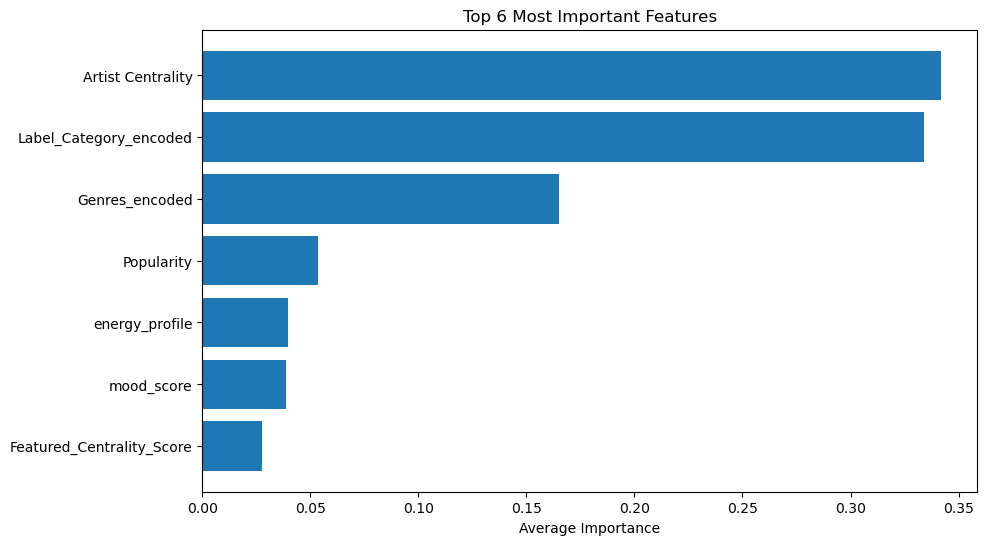

In [72]:
# Load your similar artists data
df_liked_similar = pd.read_csv('data/liked_artists_only_similar.csv')

# Create known artists set
known_artists = set(df_liked_similar['Artist'])

features = [
    'Popularity', 'Genres_encoded', 'Artist Centrality', 'Featured_Centrality_Score',
    'Label_Category_encoded', 'mood_score', 'energy_profile'
]

# Normalize the target variable
y_mean = df['liked'].mean()
y_std = df['liked'].std()
y_normalized = (df['liked'] - y_mean) / y_std

# Prepare training data
X = df[features]
y = y_normalized  # Use normalized target

# Initialize models with the best parameters from tuning
rf_model = RandomForestRegressor(**rf_params, random_state=42)
xgb_model = XGBRegressor(**xgb_params, random_state=42)

# Train models
rf_model.fit(X, y)
xgb_model.fit(X, y)

# Get feature importance from both models
rf_importance = pd.DataFrame({
    'feature': features,
    'importance_rf': rf_model.feature_importances_
}).sort_values('importance_rf', ascending=False)

xgb_importance = pd.DataFrame({
    'feature': features,
    'importance_xgb': xgb_model.feature_importances_
}).sort_values('importance_xgb', ascending=False)

# Combine importance scores
feature_importance = pd.merge(rf_importance, xgb_importance, on='feature')
feature_importance['avg_importance'] = (feature_importance['importance_rf'] + feature_importance['importance_xgb']) / 2
feature_importance = feature_importance.sort_values('avg_importance', ascending=False)

# Prepare NMF data for prediction
df_nmf_cleaned = df_nmf[features]

# Make predictions and denormalize
rf_predictions = rf_model.predict(df_nmf_cleaned) * y_std + y_mean
xgb_predictions = xgb_model.predict(df_nmf_cleaned) * y_std + y_mean

# Combine predictions (ensemble)
final_predictions = (rf_predictions + xgb_predictions) / 2

# MODIFIED SECTION - Apply artist boost
df_nmf['is_unknown_artist'] = ~df_nmf['Artist Name(s)'].isin(known_artists)
df_nmf['predicted_score'] = final_predictions + (df_nmf['is_unknown_artist'] * 2.5)

# Get prediction intervals
def get_prediction_interval(X, model, percentile=95):
    predictions = []
    for estimator in model.estimators_:
        predictions.append(estimator.predict(X) * y_std + y_mean)
    predictions = np.array(predictions)
    lower = np.percentile(predictions, (100-percentile)/2, axis=0)
    upper = np.percentile(predictions, 100-(100-percentile)/2, axis=0)
    return lower, upper

# Calculate prediction intervals
lower_bound, upper_bound = get_prediction_interval(df_nmf_cleaned, rf_model)
df_nmf['prediction_lower'] = lower_bound
df_nmf['prediction_upper'] = upper_bound
df_nmf['prediction_uncertainty'] = upper_bound - lower_bound

# Get the most common release date from NMF dataset
nmf_release_date = df_nmf['Release Date'].mode().iloc[0]

album_predictions = df_nmf.groupby('Album Name').agg({
    'Artist Name(s)': 'first',
    'predicted_score': ['mean', 'std', 'count'],
    'prediction_uncertainty': 'mean',
    'Genres': lambda x: ' | '.join(list(set(x))[:3]),
    'Record Label': 'first',
    'Artist Centrality': 'first',  
    'mood_score': 'first',         
    'energy_profile': 'first'     
}).reset_index()


# Flatten column names
album_predictions.columns = [
    'Album Name', 'Artist', 'avg_score', 'score_std', 'track_count',
    'avg_uncertainty', 'Genres', 'Label', 'Artist_Centrality', 
    'Mood_Score', 'Energy_Profile'
]

# Calculate confidence score (unchanged)
max_std = album_predictions['score_std'].max()
max_uncertainty = album_predictions['avg_uncertainty'].max()

album_predictions['confidence_score'] = (
    (1 - album_predictions['score_std'] / max_std) * 
    (1 - album_predictions['avg_uncertainty'] / max_uncertainty) * 
    (1 - 1/(1 + album_predictions['track_count']))
) * 100

album_predictions['confidence_score'] = np.clip(
    album_predictions['confidence_score'], a_min=1, a_max=100
)

# Sort by average score
album_recommendations = album_predictions.sort_values('avg_score', ascending=False)

# Define output columns with original values
output_columns = [
    'Artist', 'Album Name', 'avg_score', 'confidence_score',
    'Genres', 'Label', 'Artist_Centrality', 'Mood_Score', 'Energy_Profile'
]

# Format the date for the filename
date_str = datetime.strptime(nmf_release_date, '%Y-%m-%d').strftime('%m-%d-%y')
filename = f"{date_str}_Album_Recommendations.csv"

# Save recommendations with rounded numbers and scale adjustments
final_recommendations = album_recommendations[output_columns].copy()
final_recommendations['Artist_Centrality'] = final_recommendations['Artist_Centrality'] * 100
final_recommendations['Mood_Score'] = final_recommendations['Mood_Score'].clip(0, 1) * 100
final_recommendations['Energy_Profile'] = final_recommendations['Energy_Profile'].clip(0, 1) * 100

final_recommendations.round(2).to_csv(f'predictions/{filename}', index=False)

# Define the custom scorer for cross-validation
def custom_scorer(y_true, y_pred):
    y_true_denormalized = y_true * y_std + y_mean
    y_pred_denormalized = y_pred * y_std + y_mean
    return -mean_squared_error(y_true_denormalized, y_pred_denormalized)

# Wrap the custom scorer
custom_scorer_func = make_scorer(custom_scorer, greater_is_better=False)

# Evaluate models using cross-validation
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring=custom_scorer_func)
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring=custom_scorer_func)

# Print results with improved formatting
print(f"\n=== New Music Friday Recommendations ({nmf_release_date}) ===\n")

# Display top 20 recommended albums with clean formatting
print("Top 20 Albums by Average Score:")
display_cols = ['Artist', 'Album Name', 'avg_score']
print(album_recommendations[display_cols].head(20).round(2).to_string(index=False))

# Print model performance metrics
print("\n=== Model Performance ===")
print(f"Random Forest CV Score: {rf_cv_scores.mean():.3f} (+/- {rf_cv_scores.std() * 2:.3f})")
print(f"XGBoost CV Score: {xgb_cv_scores.mean():.3f} (+/- {xgb_cv_scores.std() * 2:.3f})")

# Display feature importance
print("\n=== Feature Importance ===")
print(feature_importance[['feature', 'avg_importance']].round(3).to_string(index=False))

# Visualization for feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['avg_importance'])
plt.xlabel('Average Importance')
plt.title('Top 6 Most Important Features')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

### Display the Top Recommended Albums!

In [73]:
# Folder where the predictions are saved
predictions_folder = "predictions/"

# Get the latest predictions file
files = [f for f in os.listdir(predictions_folder) if f.endswith("_Album_Recommendations.csv")]

if files:
    thisweek = max(files, key=lambda f: os.path.getmtime(os.path.join(predictions_folder, f)))
    print(f"Loaded latest file: {thisweek}")  # Optional, just for confirmation
    model_output_df = pd.read_csv(os.path.join(predictions_folder, thisweek))
    model_output_df = model_output_df.sort_values(by="avg_score", ascending=False)

    # Display all rows
    pd.set_option("display.max_rows", None)
    model_output_df
else:
    thisweek = None
    None  # Ensures no unwanted output

thisweek  # Stores the filename for reference
model_output_df  #Show the Recommendations Dataframe for This Past Week!

Loaded latest file: 02-21-25_Album_Recommendations.csv


,Artist,Album Name,avg_score,confidence_score,Genres,Label,Artist_Centrality,Mood_Score,Energy_Profile
0,Sunny War,Armageddon In A Summer Dress,89.47,2.72,"female vocalist, folk, singer-songwriter, blue...","New West Records, LLC",-51.84,0.00,100.00
1,Luke Sital-Singh,Fool's Spring,88.90,21.00,"folk, acoustic, british, singer-songwriter, ma...",Nettwerk Music Group,-48.81,30.05,0.00
2,Youth Lagoon,Rarely Do I Dream,88.70,17.23,"dream pop, lo-fi, indie, chillwave, glo-fi, in...",Fat Possum,-47.46,100.00,0.00
3,Paris Texas,They Left Me With The Sword,86.49,19.72,"electronic, rap, hip-hop, rap rock, hip hop, r...",Paris Texas LLC,-159.40,0.00,100.00
4,Imagine Dragons,Reflections (From The Vault Of Smoke + Mirrors),86.19,25.72,"indie, indie rock, alternative, rock, indie po...",Kid Ina Korner / Interscope,-158.72,50.26,0.00
5,Anxious,Bambi,85.49,17.91,"melodic hardcore, emo, alternative rock, hardc...",Run For Cover Records,44.73,0.00,100.00
6,Sam Fender,People Watching,85.04,24.10,"indie rock, indie, rock, british, heartland ro...",Polydor Records,-159.84,22.66,100.00
7,Tate McRae,So Close To What,83.00,21.59,"female vocalist, pop, canadian, electronic, el...",RCA Records Label,-150.65,13.36,0.00
8,Patterson Hood,Exploding Trees & Airplane Screams,82.99,2.26,"alt-country, americana, singer-songwriter, sou...",ATO Records,-192.07,0.00,0.00
9,Jesse Welles,Middle,82.61,1.00,"folk, protest music, singer-songwriter, usa, c...",Jesse Welles,25.86,100.00,56.65


## Grab Album Art for the NMF Albums

In [90]:
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from time import sleep
from datetime import datetime
from typing import Dict

# Your Last.fm API key
LASTFM_API_KEY = "74a510ecc9fc62bf3e0edc6adc2e99f9"

# Function to get similar artists using Last.fm API
def get_similar_artists(artist: str, api_key: str, limit: int = 5) -> Dict:
    """
    Get similar artists using Last.fm API.
    Returns dict with artist and similar artists list.
    """
    base_url = "http://ws.audioscrobbler.com/2.0/"
    params = {
        'method': 'artist.getsimilar',
        'artist': artist,
        'api_key': api_key,
        'limit': limit,
        'format': 'json'
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if 'similarartists' in data and 'artist' in data['similarartists']:
            similar_artists = [artist['name'] for artist in data['similarartists']['artist']]
            return {
                'Artist': artist,
                'Similar Artists': ", ".join(similar_artists[:limit]),
                'status': 'success'
            }
    except Exception as e:
        return {
            'Artist': artist,
            'Similar Artists': None,
            'status': f'error: {str(e)}'
        }
    
    return {
        'Artist': artist,
        'Similar Artists': None,
        'status': 'no_results'
    }

# Function to fetch album art from Discogs (backup)
def get_album_art_discogs(artist: str, album: str) -> str:
    """
    Fetch album artwork URL using Discogs API directly.
    """
    try:
        url = "https://api.discogs.com/database/search"
        params = {
            'artist': artist,
            'release_title': album,
            'type': 'release',
            'per_page': 1
        }
        headers = {
            'User-Agent': 'MyApp/1.0',  # Required by Discogs
            'Authorization': 'Discogs token=YOUR_DISCOGS_TOKEN'  # Optional: Add if you have a token
        }
        response = requests.get(url, params=params, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        if data.get('results') and data['results'][0].get('cover_image'):
            return data['results'][0]['cover_image']
    except Exception as e:
        print(f"Discogs error for {artist} - {album}: {e}")
    return None

# Function to get album art using Last.fm API (primary) and Discogs (backup)
def get_album_art(artist: str, album: str, api_key: str) -> Dict:
    """
    Search for album artwork URL using Last.fm API, with Discogs as a backup.
    Returns dict with album info and status.
    """
    base_url = "http://ws.audioscrobbler.com/2.0/"
    params = {
        'method': 'album.getinfo',
        'api_key': api_key,
        'artist': artist,
        'album': album,
        'format': 'json'
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if 'album' in data and 'image' in data['album']:
            images = data['album']['image']
            largest_image = images[-1]['#text'] if images else None
            if largest_image:
                return {
                    'Artist': artist,
                    'Album Name': album,
                    'Album Art': largest_image,
                    'status': 'success (Last.fm)'
                }
        
        # If Last.fm fails, try Discogs as a backup
        discogs_art = get_album_art_discogs(artist, album)
        if discogs_art:
            return {
                'Artist': artist,
                'Album Name': album,
                'Album Art': discogs_art,
                'status': 'success (Discogs)'
            }
        
        # If both APIs fail
        return {
            'Artist': artist,
            'Album Name': album,
            'Album Art': None,
            'status': 'no_results'
        }
    except Exception as e:
        return {
            'Artist': artist,
            'Album Name': album,
            'Album Art': None,
            'status': f'error: {str(e)}'
        }

# Main function to update album data
def update_album_data(input_file: str, album_art_file: str, similar_artists_file: str, api_key: str) -> None:
    """
    Fetch fresh album cover art and similar artists data for the current playlist.
    """
    print(f"\nStarting data fetch at {datetime.now().strftime('%H:%M:%S')}")
    
    # Read input data
    df_input = pd.read_csv(input_file)
    
    # Get all unique artist/album pairs from the input data
    album_pairs = df_input[['Primary Artist', 'Album Name']].drop_duplicates()
    
    # Get all recommended artists (from df_nmf tracks)
    recommended_artists = df_input[df_input['playlist_origin'] == 'df_nmf']['Primary Artist'].unique()
    
    # Initialize empty DataFrames for new data
    df_album_art = pd.DataFrame(columns=['Artist', 'Album Name', 'Album Art'])
    df_similar = pd.DataFrame(columns=['Artist', 'Similar Artists'])
    
    print(f"\nNeed to fetch:")
    print(f"- Album artwork: {len(album_pairs)}")
    print(f"- Similar artists for recommended artists: {len(recommended_artists)}")
    
    # Process album art for all tracks
    print("\nFetching album artwork...")
    album_entries = []
    successful_albums = 0
    failed_albums = 0
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_album = {
            executor.submit(get_album_art, row['Primary Artist'], row['Album Name'], api_key): (row['Primary Artist'], row['Album Name'])
            for _, row in album_pairs.iterrows()
        }
        
        for i, future in enumerate(as_completed(future_to_album), 1):
            result = future.result()
            if result['status'].startswith('success') and result['Album Art']:
                album_entries.append({
                    'Artist': result['Artist'],
                    'Album Name': result['Album Name'],
                    'Album Art': result['Album Art']
                })
                successful_albums += 1
            else:
                failed_albums += 1
            
            if i % 5 == 0 or i == len(album_pairs):
                print(f"Album Progress: {i}/{len(album_pairs)} | Success: {successful_albums} | Failed: {failed_albums}")
            
            sleep(0.25)
    
    if album_entries:
        df_album_art = pd.DataFrame(album_entries)
        df_album_art.to_csv(album_art_file, index=False)
    
    # Process similar artists for recommended artists
    print("\nFetching similar artists...")
    artist_entries = []
    successful_artists = 0
    failed_artists = 0
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_artist = {
            executor.submit(get_similar_artists, artist, api_key): artist
            for artist in recommended_artists
        }
        
        for i, future in enumerate(as_completed(future_to_artist), 1):
            result = future.result()
            if result['status'] == 'success' and result['Similar Artists']:
                artist_entries.append({
                    'Artist': result['Artist'],
                    'Similar Artists': result['Similar Artists']
                })
                successful_artists += 1
            else:
                failed_artists += 1
            
            if i % 5 == 0 or i == len(recommended_artists):
                print(f"Artist Progress: {i}/{len(recommended_artists)} | Success: {successful_artists} | Failed: {failed_artists}")
            
            sleep(0.25)
    
    if artist_entries:
        df_similar = pd.DataFrame(artist_entries)
        df_similar.to_csv(similar_artists_file, index=False)
    
    print(f"\nFinished at {datetime.now().strftime('%H:%M:%S')}")
    print(f"Summary:")
    print(f"- Album artwork added: {successful_albums}")
    print(f"- Album artwork failed: {failed_albums}")
    print(f"- Similar artists added: {successful_artists}")
    print(f"- Similar artists failed: {failed_artists}")
    print(f"- Total albums in database: {len(df_album_art)}")
    print(f"- Total artists in database: {len(df_similar)}")

# Usage
if __name__ == "__main__":
    input_file = "data/df_nmf_later.csv"  # Replace with your input file path
    album_art_file = "data/nmf_album_covers.csv"  # Replace with your output file path
    similar_artists_file = "data/nmf_similar_artists.csv"  # Replace with your output file path
    update_album_data(input_file, album_art_file, similar_artists_file, LASTFM_API_KEY)


Starting data fetch at 15:21:06

Need to fetch:
- Album artwork: 43
- Similar artists for recommended artists: 43

Fetching album artwork...
Album Progress: 5/43 | Success: 5 | Failed: 0
Album Progress: 10/43 | Success: 10 | Failed: 0
Discogs error for Paul Thorn - Life Is Just A Vapor: 401 Client Error: Unauthorized for url: https://api.discogs.com/database/search?artist=Paul+Thorn&release_title=Life+Is+Just+A+Vapor&type=release&per_page=1
Album Progress: 15/43 | Success: 14 | Failed: 1
Discogs error for Souled American - Rise Above It: A Souled American Anthology: 401 Client Error: Unauthorized for url: https://api.discogs.com/database/search?artist=Souled+American&release_title=Rise+Above+It%3A+A+Souled+American+Anthology&type=release&per_page=1
Album Progress: 20/43 | Success: 18 | Failed: 2
Album Progress: 25/43 | Success: 23 | Failed: 2
Album Progress: 30/43 | Success: 28 | Failed: 2
Album Progress: 35/43 | Success: 33 | Failed: 2
Discogs error for Mandrake Handshake - Earth-Siz

## Grab the Spotify Link for each New Music Friday Album

In [82]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time

def generate_spotify_links():
    # Initialize Spotify client with your credentials
    client_id = "71faef9605da4db495b691d96a0daa4b"
    client_secret = "832e40da22e049bba93f29d9dbeb2e62"
    
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
        client_id=client_id,
        client_secret=client_secret
    ))
    
    # Read the NMF data
    df = pd.read_csv('data/nmf.csv')
    
    # Get unique albums
    albums = df.drop_duplicates(subset=['Album Name'], keep='first')
    
    # Function to get album ID from track with rate limiting
    def get_album_id(track_id):
        try:
            # Add delay to respect rate limits
            time.sleep(0.1)  # 100ms delay between requests
            track_info = sp.track(track_id)
            return track_info['album']['id']
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:  # Too Many Requests
                print("Rate limit hit, waiting longer...")
                time.sleep(5)  # Wait 5 seconds before retrying
                try:
                    track_info = sp.track(track_id)
                    return track_info['album']['id']
                except:
                    print(f"Still failed after retry for track {track_id}")
                    return None
            else:
                print(f"Error getting album ID for track {track_id}: {e}")
                return None
        except Exception as e:
            print(f"Unexpected error for track {track_id}: {e}")
            return None
    
    print(f"Processing {len(albums)} albums...")
    
    # Get album IDs and generate URLs
    albums['Album ID'] = albums['Track ID'].apply(get_album_id)
    
    # Filter out any failed lookups
    albums = albums.dropna(subset=['Album ID'])
    
    albums['Spotify URL'] = 'open.spotify.com/album/' + albums['Album ID'].astype(str)
    
    # Select and reorder columns for output
    output_df = albums[['Album Name', 'Artist Name(s)', 'Album ID', 'Spotify URL']]
    
    # Save to CSV
    output_df.to_csv('data/nmf_album_links.csv', index=False)
    
    print(f"Successfully generated album links for {len(output_df)} albums")
    return output_df

if __name__ == "__main__":
    generate_spotify_links()

Processing 44 albums...
Successfully generated album links for 44 albums
